In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,Ridge
from visualization_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import SplineTransformer



In [2]:
TRAIN_MODELS = False
results = []

In [8]:
def impute_missing_numerical_values(df, numerical_columns):
    for col in numerical_columns:
        median = df[col].median()
        df[col] = df[col].fillna(median)
    return df

def generate_polynomial_features(df,log_columns=False,degree_columns=True,mean_column_interactions = False):
    #Adding Polynomial features and interaction terms
    if log_columns:
        df['logYear'] = np.log(df['Year'])
        df['logHorsepower'] = np.log(df['Horsepower'])
        df['logKMDriven'] = np.log(df['KmDriven'])
        df['logCubicCapacity'] = np.log(df['CubicCapacity'])
        df['logYear*logHorsepower'] = df['logYear']*df['logHorsepower']
        df['logYear*logKMDriven'] = df['logYear']*df['logKMDriven']
        df['logHorsepower*logKMDriven'] = df['logHorsepower']*df['logKMDriven']
        if mean_column_interactions:
            df['logYear*MeanPriceByModel'] = df['logYear']*df['MeanPriceByModel']
            df['logHorsepower*MeanPriceByModel'] = df['logHorsepower']*df['MeanPriceByModel']
            df['logKMDriven*MeanPriceByModel'] = df['logKMDriven']*df['MeanPriceByModel']
            df['logCubicCapacity*MeanPriceByModel'] = df['logCubicCapacity']*df['MeanPriceByModel']
            df['logYear*StdPriceByModel'] = df['logYear']*df['StdPriceByModel']
            df['logHorsepower*StdPriceByModel'] = df['logHorsepower']*df['StdPriceByModel']
            df['logKMDriven*StdPriceByModel'] = df['logKMDriven']*df['StdPriceByModel']
            df['logCubicCapacity*StdPriceByModel'] = df['logCubicCapacity']*df['StdPriceByModel']

    if degree_columns:
        df['Horsepower^2'] = df['Horsepower']**2
        df['Horsepower^3'] = df['Horsepower']**3
        df['YearsSince1980^2'] = (df['Year']-1980)**2
        df['YearsSince1980^3'] = (df['Year']-1980)**3
        df['(ThousandKmDriven)^2'] = (df['KmDriven']/1000)**2
        df['(ThousandKmDriven)^3'] = (df['KmDriven']/1000)**3
        #Interaction terms
        df['Horsepower*YearsSince1980'] = df['Horsepower']*(df['Year']-1980)
        df['Horsepower*ThousandKmDriven'] = df['Horsepower']*(df['KmDriven']/1000)
        df['YearsSince1980*ThousandKmDriven'] = (df['Year']-1980)*(df['KmDriven']/1000)
        if mean_column_interactions:
            df['Horsepower*MeanPriceByModel'] = df['Horsepower']*df['MeanPriceByModel']
            df['YearsSince1980*MeanPriceByModel'] = (df['Year']-1980)*df['MeanPriceByModel']
            df['ThousandKmDriven*MeanPriceByModel'] = (df['KmDriven']/1000)*df['MeanPriceByModel']
            df['Horsepower*StdPriceByModel'] = df['Horsepower']*df['StdPriceByModel']
            df['YearsSince1980*StdPriceByModel'] = (df['Year']-1980)*df['StdPriceByModel']
            df['ThousandKmDriven*StdPriceByModel'] = (df['KmDriven']/1000)*df['StdPriceByModel']

def get_split_data(df, target_column):
    y=df[target_column]
    X=df.drop(columns=[target_column])
    return train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test,train_model=True,is_log_transform=False,display_graphs=True):
    if train_model:
        model.fit(X_train, y_train)
    results_train = model.predict(X_train)
    results_test = model.predict(X_test)
    if is_log_transform:
        results_train = np.exp(results_train)
        results_test = np.exp(results_test)
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
    train_r2 = r2_score(y_train,results_train)
    test_r2 = r2_score(y_test,results_test)
    train_rmse = root_mean_squared_error(y_train,results_train)
    test_rmse = root_mean_squared_error(y_test,results_test)
    train_mae = mean_absolute_error(y_train,results_train)
    test_mae = mean_absolute_error(y_test,results_test)
    train_score_adj_r2 = 1 - (1 - train_r2) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)
    test_score_adj_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    print(f"Train R2: {round(train_r2, 4)}")
    print(f"Train Adjusted R2: {round(train_score_adj_r2, 4)}")
    print(f"Train RMSE: {round(train_rmse, 4)}")
    print(f"Train MAE: {round(train_mae,4)}")
    print(f"Test R2: {round(test_r2, 4)}")
    print(f"Test Adjusted R2: {round(test_score_adj_r2, 4)}")
    print(f"Test RMSE: {round(test_rmse, 4)}")
    print(f"Test MAE: {round(test_mae,4)}")
    if display_graphs:
        sns.regplot(x=y_test, y=results_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.grid(True)
        plt.show()
        residuals = y_test-results_test
        sns.histplot(residuals,bins=100)
    return train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse

def read_data(file_path,drop_model_column=True):
    df = pd.read_csv(file_path)
    # New feature: isElectric
    df['isElectric'] = ~df['WLTP_Range_km'].isna() | ~df['Battery_Capacity_kWh'].isna()
    # Impute missing values for electric car features with 0
    df['WLTP_Range_km'] = df['WLTP_Range_km'].fillna(0)
    df['Battery_Capacity_kWh'] = df['Battery_Capacity_kWh'].fillna(0)
    # Not used columns
    df = df.drop(columns=['Month']) # Not useful for prediction
    df = df.drop(columns=['URL']) # Not useful for prediction
    df = df.drop(columns=['Area']) # Very correlated with City and City has less missing values
    if not drop_model_column:
        model_processed=df['Model'].str.split(' ').str[1].str.lower().str.strip()
    
    df = df.drop(columns=['Model']) # Too many unique values

    df = df.drop(columns=['Status']) # Artificial column created by mobile bg
    df = df.drop(columns=['Condition']) # 97% empty
    df = impute_missing_numerical_values(df, ['Year', 'Horsepower', 'CubicCapacity', 'KmDriven'])
    print("Before onehot encoding",df.shape)
    df = pd.get_dummies(df,drop_first=True)
    print("After onehot encoding",df.shape)
    if not drop_model_column:
        df['Model'] = model_processed
    return df

def handle_model_column(X_train, X_test):
    counts = X_train['Model'].value_counts()
    counts = counts[counts >= 10]
    possible_values = set(counts.index.tolist())
    X_train.loc[~X_train['Model'].isin(possible_values), "Model"] = 'Other'
    X_test.loc[~X_test['Model'].isin(possible_values), "Model"] = 'Other'

    values = X_train.groupby('Model')['CarPrice'].agg(['mean','std']).sort_values(by='mean', ascending=False)

    X_train['MeanPriceByModel'] = X_train['Model'].map(values['mean'])
    X_train['StdPriceByModel'] = X_train['Model'].map(values['std'])
    X_train['VariancePriceByModel'] = X_train['Model'].map(values['std']**2)
    X_test['MeanPriceByModel'] = X_test['Model'].map(values['mean'])
    X_test['StdPriceByModel'] = X_test['Model'].map(values['std'])
    X_test['VariancePriceByModel'] = X_test['Model'].map(values['std']**2)

In [4]:
df = read_data('processed_data/preprocessed_car_data.csv')
display(df)

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)


,CarPrice,Year,Horsepower,CubicCapacity,KmDriven,WLTP_Range_km,Battery_Capacity_kWh,Система за изсушаване на накладките,Въздушни възглавници - Задни,Парктроник,...,Color_бял,Color_графит,Color_зелен,Color_кафяв,Color_металик,Color_сив,Color_син,Color_сребърен,Color_червен,Color_черен
0,58000.0,2019.0,286.0,3000.0,170000.0,0.0,0.0,True,True,True,...,False,False,False,False,False,False,True,False,False,False
1,69999.0,2023.0,204.0,2000.0,195194.0,0.0,0.0,False,True,True,...,False,False,False,False,False,False,False,False,False,True
2,56990.0,2020.0,349.0,2000.0,152000.0,0.0,0.0,False,True,True,...,False,False,False,False,False,False,False,False,False,True
3,71999.0,2020.0,286.0,3000.0,170500.0,0.0,0.0,False,True,True,...,False,False,False,False,False,False,False,False,False,False
4,77000.0,2019.0,286.0,2000.0,134257.0,0.0,0.0,False,True,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110694,10500.0,2013.0,63.0,1197.0,160000.0,0.0,0.0,False,True,False,...,True,False,False,False,False,False,False,False,False,False
110695,10500.0,2013.0,105.0,1200.0,175500.0,0.0,0.0,False,False,True,...,False,False,False,False,False,False,False,False,False,True
110696,10000.0,2012.0,169.0,2000.0,190000.0,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
110697,10199.0,2013.0,86.0,1200.0,150000.0,0.0,0.0,False,True,False,...,False,False,False,True,False,False,False,False,False,False


Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.6761
Train Adjusted R2: 0.6753
Train RMSE: 23202.134
Test R2: 0.6606
Test Adjusted R2: 0.6587
Test RMSE: 23869.8942


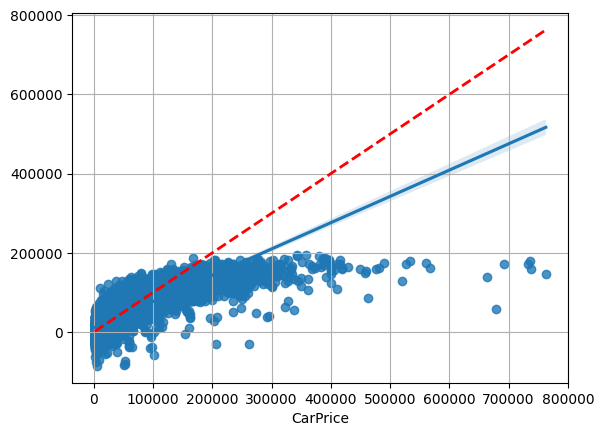

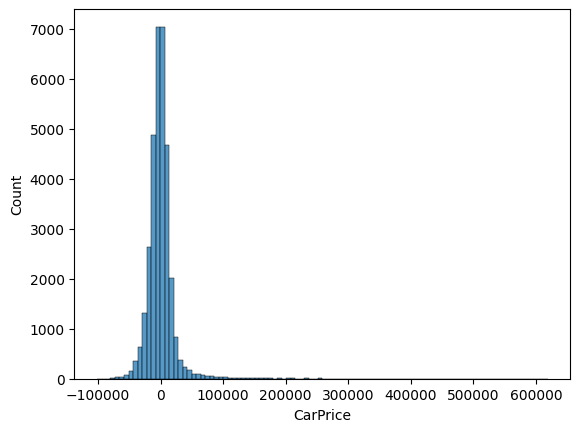

In [9]:
# Baseline
df = read_data('processed_data/preprocessed_car_data.csv')

X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
if TRAIN_MODELS:

    train_and_evaluate_model(baseline_model, X_train, y_train, X_test, y_test)
    with open('linear_models/baseline_model.pkl', 'wb') as fid:
        pickle.dump(baseline_model, fid)
else:
    with open('linear_models/baseline_model.pkl', 'rb') as fid:
        baseline_model = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(baseline_model, X_train, y_train, X_test, y_test,train_model=False)
    results.append({
        'Model':'Baseline Linear Regression',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })

In [ ]:
# Polynomial Regression
df = read_data('processed_data/preprocessed_car_data.csv')

baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])

generate_polynomial_features(df)
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')

params = {'regressor__alpha':[0.001,0.01, 0.1],
        'regressor__l1_ratio':[0.5,0.6,0.7,0.8,1]}
if TRAIN_MODELS:

    grid_search_with_polynomial = GridSearchCV(baseline_model, params, cv=3)
    grid_search_with_polynomial.fit(X_train,y_train)
    print("best params:",grid_search_with_polynomial.best_params_)
    print("best score:",grid_search_with_polynomial.best_score_)
    with open('linear_models/polynomial_regression.pkl', 'wb') as fid:
        pickle.dump(grid_search_with_polynomial, fid)   
else:
    grid_search_with_polynomial = GridSearchCV(baseline_model, params, cv=3)
    with open('linear_models/polynomial_regression.pkl', 'rb') as fid:
        grid_search_with_polynomial = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(grid_search_with_polynomial,X_train, y_train, X_test, y_test,train_model=False)
    results.append({
        'Model':'Baseline Linear Regression',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)


(110699, 100)

Train R2: 0.6278
Train Adjusted R2: 0.6272
Train RMSE: 24870.8529
Test R2: 0.6071
Test Adjusted R2: 0.6057
Test RMSE: 25684.8131


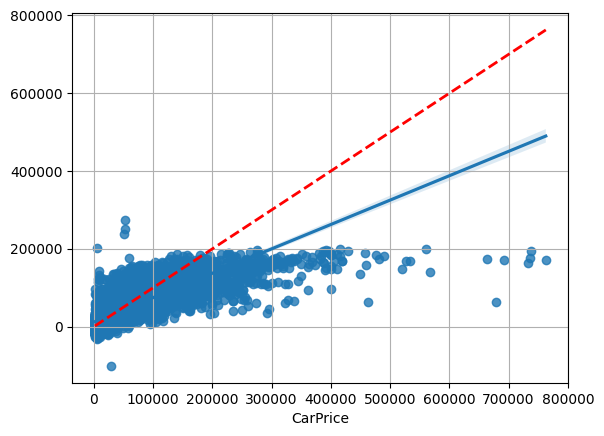

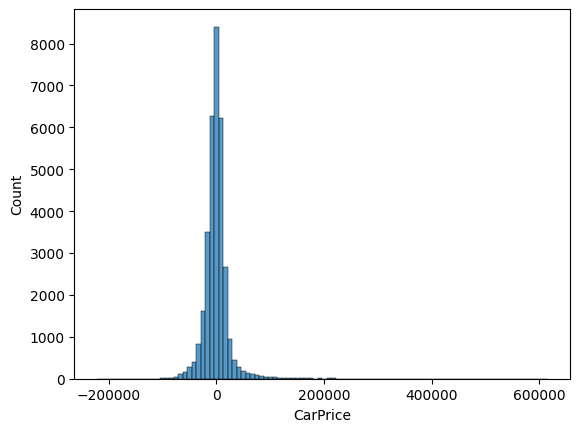

In [ ]:
# PCA on Categorical features
df = read_data('processed_data/preprocessed_car_data.csv')
generate_polynomial_features(df)

baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])
categorical_cols = df.columns.tolist()
non_categorical_cols = ['CarPrice','Year','Horsepower','CubicCapacity','KmDriven','WLTP_Range_km','Battery_Capacity_kWh','Horsepower^2','Horsepower^3','YearsSince1980^2','YearsSince1980^3','(ThousandKmDriven)^2','(ThousandKmDriven)^3','Horsepower*YearsSince1980','Horsepower*ThousandKmDriven','YearsSince1980*ThousandKmDriven']
for col in non_categorical_cols:categorical_cols.remove(col)
num_pca_columns = 100
pca = PCA(n_components=num_pca_columns)
result = pca.fit_transform(df[categorical_cols])
display(result.shape)
pca_df = df[non_categorical_cols]
pca_df = np.concatenate([pca_df, result], axis=1)
pca_df = pd.DataFrame(pca_df,columns=non_categorical_cols + [f'PCA_{i+1}' for i in range(num_pca_columns)])
X_train, X_test, y_train, y_test = get_split_data(pca_df, 'CarPrice')
if TRAIN_MODELS:

    params = {'regressor__alpha':[ 1, 5,10,20,50,100],
        'regressor__l1_ratio':[0.3,0.5,0.6,0.7,0.8,1]}
    grid_search_with_polynomial_and_pca = GridSearchCV(baseline_model, params, cv=3)
    grid_search_with_polynomial_and_pca.fit(X_train,y_train)
    print("best params:",grid_search_with_polynomial_and_pca.best_params_)
    print("best score:",grid_search_with_polynomial_and_pca.best_score_)
    with open('linear_models/polynomial_regression_with_pca.pkl', 'wb') as fid:
        pickle.dump(grid_search_with_polynomial_and_pca, fid)   
else:
    grid_search_with_polynomial_and_pca = GridSearchCV(baseline_model, params, cv=3)
    with open('linear_models/polynomial_regression_with_pca.pkl', 'rb') as fid:
        grid_search_with_polynomial_and_pca = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(grid_search_with_polynomial_and_pca,X_train, y_train, X_test, y_test,train_model=False)
    results.append({
        'Model':'Polynomial Regression with PCA',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.7556
Train Adjusted R2: 0.7515
Train RMSE: 20153.5703
Test R2: 0.7366
Test Adjusted R2: 0.726
Test RMSE: 21027.8514


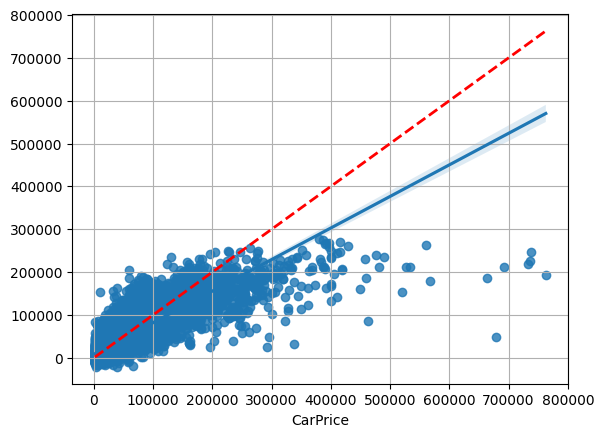

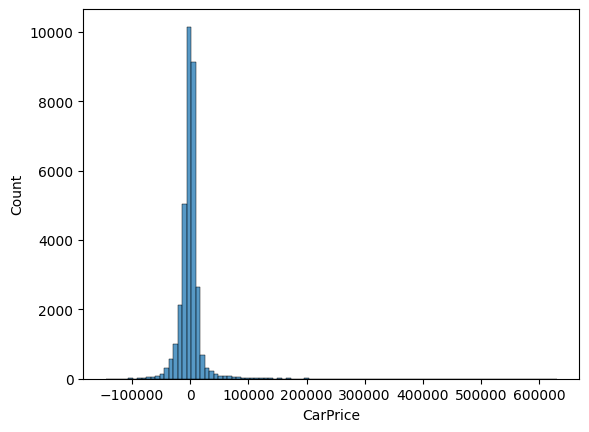

In [ ]:
# Spline Regression
df = read_data('processed_data/preprocessed_car_data.csv')
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
transformer = SplineTransformer(degree=3, n_knots=5)
transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_train.shape
if TRAIN_MODELS:

    params = {'regressor__alpha':[0.01,1,10],
            'regressor__l1_ratio':[0.2,0.5,0.8]}
    spline_search = GridSearchCV(baseline_model, params, cv=3)
    spline_search.fit(X_train,y_train)
    print("best params:",spline_search.best_params_)
    print("best score:",spline_search.best_score_)
    with open('linear_models/spline_regression.pkl', 'wb') as fid:
        pickle.dump(spline_search, fid)   

else:
    spline_search = GridSearchCV(baseline_model, params, cv=3)
    with open('linear_models/spline_regression.pkl', 'rb') as fid:
        spline_search = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(spline_search,X_train, y_train, X_test, y_test,train_model=False)
    results.append({
        'Model':'Spline Regression',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })


Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.7558
Train Adjusted R2: 0.7551
Train RMSE: 20144.9664
Test R2: 0.7369
Test Adjusted R2: 0.7351
Test RMSE: 21018.6455


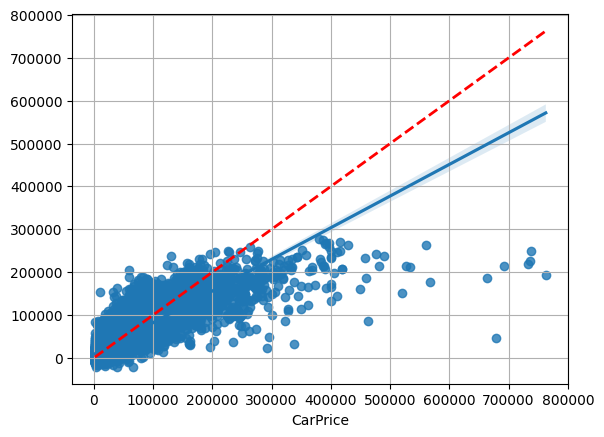

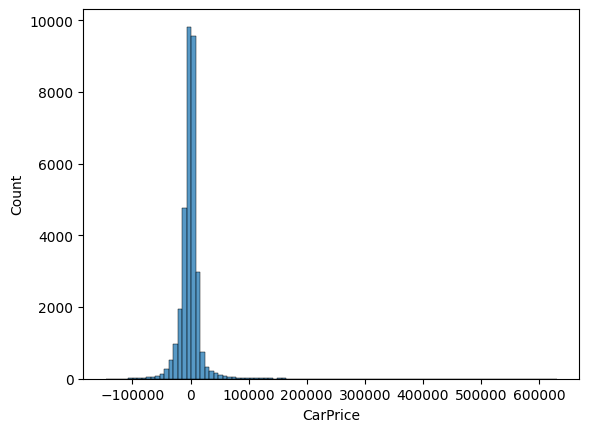

In [ ]:
# Spline on Numeric Columns only
df = read_data('processed_data/preprocessed_car_data.csv')
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])
numeric_columns =['Year','Horsepower','CubicCapacity','KmDriven','WLTP_Range_km','Battery_Capacity_kWh']
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
transformer = SplineTransformer(degree=3, n_knots=5)
transformer.fit(X_train[numeric_columns])
X_train = np.concatenate([X_train.drop(columns=numeric_columns), transformer.transform(X_train[numeric_columns])], axis=1)
X_test = np.concatenate([X_test.drop(columns=numeric_columns), transformer.transform(X_test[numeric_columns])], axis=1)
if TRAIN_MODELS:

    params = {'regressor__alpha':[0.001,1,10],
            'regressor__l1_ratio':[0.2,0.5,0.8]}
    spline_search = GridSearchCV(baseline_model, params, cv=3)
    spline_search.fit(X_train,y_train)
    print("best params:",spline_search.best_params_)
    print("best score:",spline_search.best_score_)
    with open('linear_models/spline_regression_on_numeric_columns.pkl', 'wb') as fid:
        pickle.dump(spline_search, fid)   
else:
    spline_search = GridSearchCV(baseline_model, params, cv=3)
    with open('linear_models/spline_regression_on_numeric_columns.pkl', 'rb') as fid:
        spline_search = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(spline_search,X_train, y_train, X_test, y_test,train_model=False)
    results.append({
        'Model':'Spline Regression on Numeric Columns',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })


Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.8056
Train Adjusted R2: 0.8051
Train RMSE: 17976.1614
Test R2: 0.7845
Test Adjusted R2: 0.7832
Test RMSE: 19022.3757


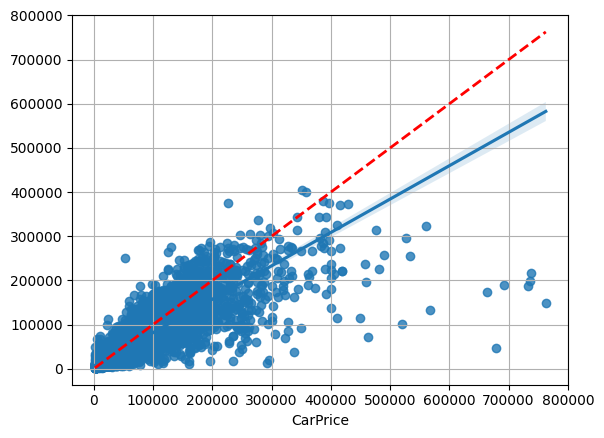

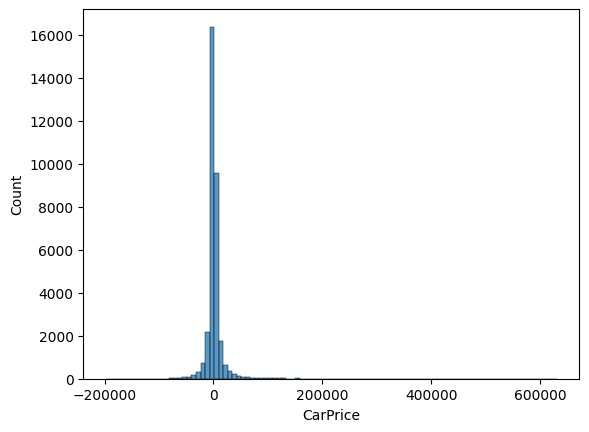

In [ ]:
# Polynomial Regression with log transform
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])
df = read_data('processed_data/preprocessed_car_data.csv')

generate_polynomial_features(df)
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
y_train = np.log(y_train)
y_test = np.log(y_test)
if TRAIN_MODELS:

    params = {'regressor__alpha':[0.001,0.01, 0.1,1,5,10,20],
            'regressor__l1_ratio':[0.01,0.3,0.5,0.7,1]}
    grid_search_with_polynomial_log = GridSearchCV(baseline_model, params, cv=3)
    grid_search_with_polynomial_log.fit(X_train,y_train)
    print("best params:",grid_search_with_polynomial_log.best_params_)
    print("best score:",grid_search_with_polynomial_log.best_score_)
    with open('linear_models/polynomial_regression_log.pkl', 'wb') as fid:
        pickle.dump(grid_search_with_polynomial_log, fid)   
else:
    grid_search_with_polynomial_log = GridSearchCV(baseline_model, params, cv=3)
    with open('linear_models/polynomial_regression_log.pkl', 'rb') as fid:
        grid_search_with_polynomial_log = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(grid_search_with_polynomial_log,X_train, y_train, X_test, y_test,train_model=False, is_log_transform=True)
    results.append({
        'Model':'Polynomial Regression with Log Transform',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.8104
Train Adjusted R2: 0.8098
Train RMSE: 17752.8608
Test R2: 0.7902
Test Adjusted R2: 0.7887
Test RMSE: 18767.623


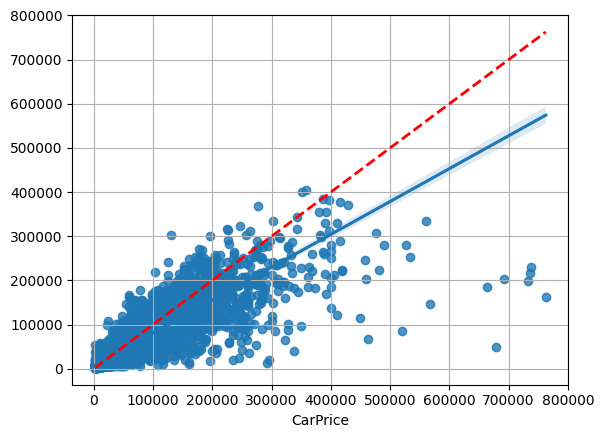

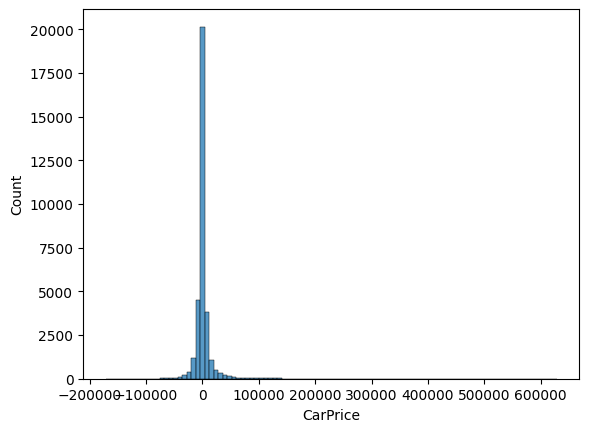

In [ ]:
# Spline on Numeric Columns only and log on target
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])
df = read_data('processed_data/preprocessed_car_data.csv')

numeric_columns =['Year','Horsepower','CubicCapacity','KmDriven','WLTP_Range_km','Battery_Capacity_kWh']
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
y_train = np.log(y_train)
y_test = np.log(y_test)
transformer = SplineTransformer(degree=4, n_knots=6)
transformer.fit(X_train[numeric_columns])
X_train = np.concatenate([X_train.drop(columns=numeric_columns), transformer.transform(X_train[numeric_columns])], axis=1)
X_test = np.concatenate([X_test.drop(columns=numeric_columns), transformer.transform(X_test[numeric_columns])], axis=1)
if TRAIN_MODELS:
    params = {'regressor__alpha':[0.001,0.01, 0.1,1,5,10,20],
        'regressor__l1_ratio':[0.01,0.3,0.5,0.7,1]}
    spline_search = GridSearchCV(baseline_model, params, cv=3)
    spline_search.fit(X_train,y_train)
    print("best params:",spline_search.best_params_)
    print("best score:",spline_search.best_score_)
    with open('linear_models/spline_regression_on_numeric_columns_log.pkl', 'wb') as fid:
        pickle.dump(spline_search, fid)   
else:
    spline_search = GridSearchCV(baseline_model, params, cv=3)
    with open('linear_models/spline_regression_on_numeric_columns_log.pkl', 'rb') as fid:
        spline_search = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(spline_search,X_train, y_train, X_test, y_test,train_model=False, is_log_transform=True)
    results.append({
        'Model':'Spline Regression on Numeric Columns with Log Transform',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.8257
Train Adjusted R2: 0.8253
Train RMSE: 17019.2968
Test R2: 0.7999
Test Adjusted R2: 0.7987
Test RMSE: 18328.4508


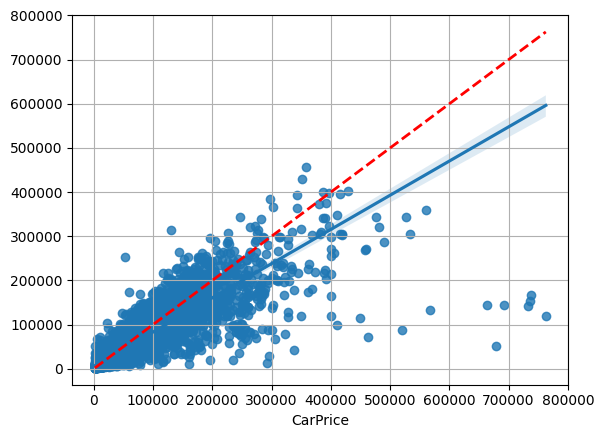

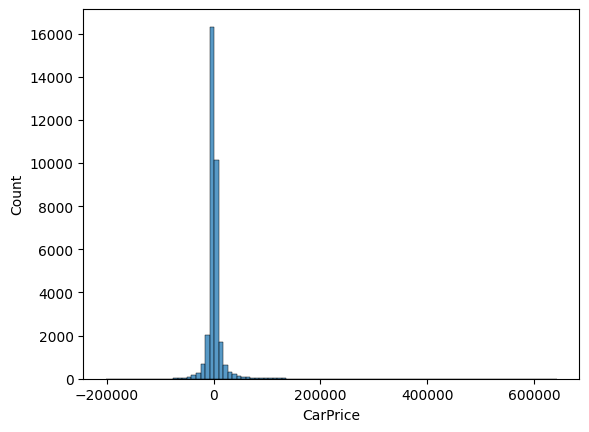

In [16]:
# Polynomial Regression with log transform and information from Model column
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])
df = read_data('processed_data/preprocessed_car_data.csv',drop_model_column=False)

generate_polynomial_features(df)
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
y_train = np.log(y_train)
y_test = np.log(y_test)
X_train['CarPrice'] = y_train

handle_model_column(X_train, X_test)
X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
if TRAIN_MODELS:

    params = {'regressor__alpha':[0.001,0.01, 0.1,1,5,10,20],
            'regressor__l1_ratio':[0.01,0.3,0.5,0.7,1]}
    grid_search_with_polynomial_log_model = GridSearchCV(baseline_model, params, cv=3)
    grid_search_with_polynomial_log_model.fit(X_train,y_train)
    print("best params:",grid_search_with_polynomial_log_model.best_params_)
    print("best score:",grid_search_with_polynomial_log_model.best_score_)
    with open('linear_models/polynomial_regression_log_model_column.pkl', 'wb') as fid:
        pickle.dump(grid_search_with_polynomial_log_model, fid)   
else:
    grid_search_with_polynomial_log_model = GridSearchCV(baseline_model, params, cv=3)
    with open('linear_models/polynomial_regression_log_model_column.pkl', 'rb') as fid:
        grid_search_with_polynomial_log_model = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(grid_search_with_polynomial_log_model,X_train, y_train, X_test, y_test,train_model=False, is_log_transform=True)
    results.append({
        'Model':'Polynomial Regression with Log Transform',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })

In [9]:
TRAIN_MODELS = True

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.8139
Train Adjusted R2: 0.8133
Train RMSE: 17587.9338
Test R2: 0.7936
Test Adjusted R2: 0.7921
Test RMSE: 18616.434


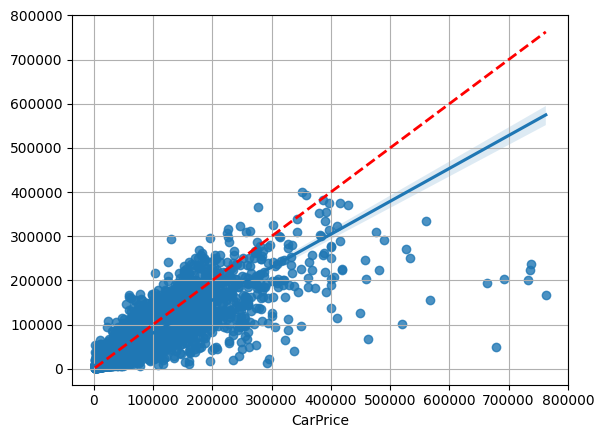

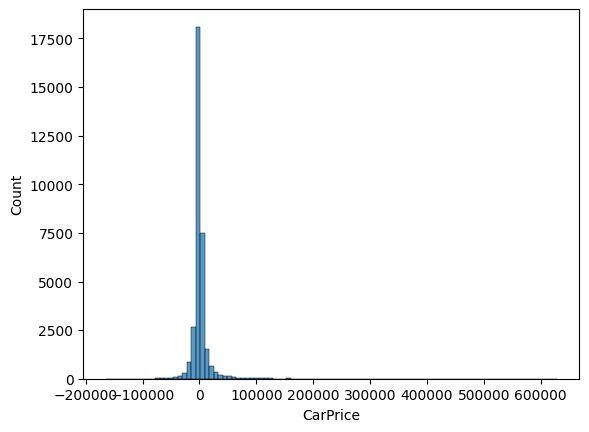

In [8]:
# Spline on Numeric Columns only and log on target and polynomial features
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])
df = read_data('processed_data/preprocessed_car_data.csv')

numeric_columns =['Year','Horsepower','CubicCapacity','KmDriven','WLTP_Range_km','Battery_Capacity_kWh']#,'MeanPriceByModel','StdPriceByModel','VariancePriceByModel']
generate_polynomial_features(df)

X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
y_train = np.log(y_train)
y_test = np.log(y_test)

transformer = SplineTransformer(degree=4, n_knots=6)
transformer.fit(X_train[numeric_columns])
X_train = np.concatenate([X_train.drop(columns=numeric_columns), transformer.transform(X_train[numeric_columns])], axis=1)
X_test = np.concatenate([X_test.drop(columns=numeric_columns), transformer.transform(X_test[numeric_columns])], axis=1)



if TRAIN_MODELS:
    params = {'regressor__alpha':[0.001,0.01, 0.1,1,5,10,20],
        'regressor__l1_ratio':[0.01,0.3,0.5,0.7,1]}
    spline_search_with_log_and_model = GridSearchCV(baseline_model, params, cv=3)
    spline_search_with_log_and_model.fit(X_train,y_train)
    print("best params:",spline_search_with_log_and_model.best_params_)
    print("best score:",spline_search_with_log_and_model.best_score_)
    with open('linear_models/spline_regression_on_numeric_columns_log_model.pkl', 'wb') as fid:
        pickle.dump(spline_search_with_log_and_model, fid)   
else:
    spline_search_with_log_and_model = GridSearchCV(baseline_model, params, cv=3)
    with open('linear_models/spline_regression_on_numeric_columns_log_model.pkl', 'rb') as fid:
        spline_search_with_log_and_model = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(spline_search_with_log_and_model,X_train, y_train, X_test, y_test,train_model=False, is_log_transform=True)
    results.append({
        'Model':'Spline Regression on Numeric Columns with Log Transform',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })

In [4]:
TRAIN_MODELS = False

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.8573
Train Adjusted R2: 0.8568
Train RMSE: 15401.7963
Train MAE: 6257.569
Test R2: 0.8323
Test Adjusted R2: 0.8309
Test RMSE: 16780.4048
Test MAE: 6544.892


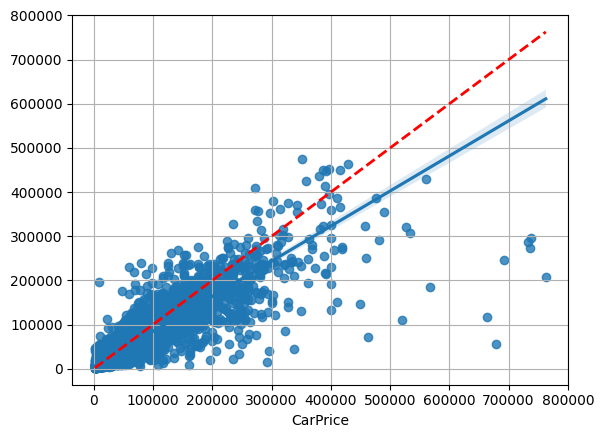

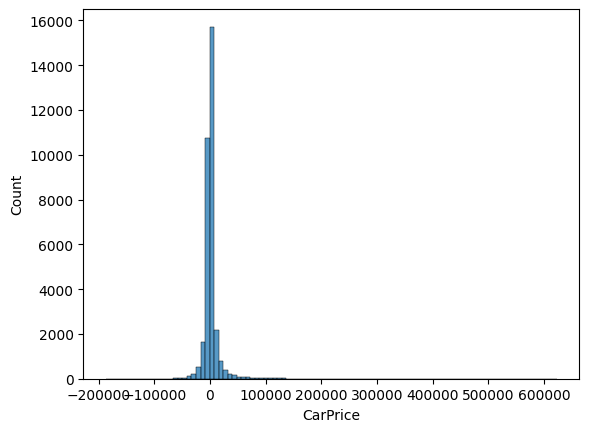

In [9]:
# Spline on Numeric Columns only and log on target with model column info and polynomial features
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])
df = read_data('processed_data/preprocessed_car_data.csv', drop_model_column=False)

numeric_columns =['Year','Horsepower','CubicCapacity','KmDriven','WLTP_Range_km','Battery_Capacity_kWh']#,'MeanPriceByModel','StdPriceByModel','VariancePriceByModel']

X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
y_train = np.log(y_train)
y_test = np.log(y_test)

X_train['CarPrice'] = y_train

handle_model_column(X_train, X_test)
X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
generate_polynomial_features(X_train,log_columns=True,degree_columns=True,mean_column_interactions=True)
generate_polynomial_features(X_test,log_columns=True,degree_columns=True,mean_column_interactions=True)

transformer = SplineTransformer(degree=4, n_knots=6)
transformer.fit(X_train[numeric_columns])
X_train = np.concatenate([X_train.drop(columns=numeric_columns), transformer.transform(X_train[numeric_columns])], axis=1)
X_test = np.concatenate([X_test.drop(columns=numeric_columns), transformer.transform(X_test[numeric_columns])], axis=1)



if TRAIN_MODELS:
    params = {'regressor__alpha':[0.001,0.01, 0.1,1,5,10,20],
        'regressor__l1_ratio':[0.01,0.3,0.5,0.7,1]}
    spline_search_with_log_and_model = GridSearchCV(baseline_model, params, cv=3)
    spline_search_with_log_and_model.fit(X_train,y_train)
    print("best params:",spline_search_with_log_and_model.best_params_)
    print("best score:",spline_search_with_log_and_model.best_score_)
    with open('linear_models/spline_regression_on_numeric_columns_log_model.pkl', 'wb') as fid:
        pickle.dump(spline_search_with_log_and_model, fid)   
else:
    spline_search_with_log_and_model = GridSearchCV(baseline_model,{}, cv=3)
    with open('linear_models/spline_regression_on_numeric_columns_log_model.pkl', 'rb') as fid:
        spline_search_with_log_and_model = pickle.load(fid)
        train_r2,train_score_adj_r2,train_rmse,test_r2,test_score_adj_r2,test_rmse = train_and_evaluate_model(spline_search_with_log_and_model,X_train, y_train, X_test, y_test,train_model=False, is_log_transform=True)
    results.append({
        'Model':'Spline Regression on Numeric Columns with Log Transform',
        'Train R2':train_r2,
        'Train Adjusted R2':train_score_adj_r2,
        'Train RMSE':train_rmse,
        'Test R2':test_r2,
        'Test Adjusted R2':test_score_adj_r2,
        'Test RMSE':test_rmse
    })

In [19]:
#df = pd.DataFrame(results)
#df.to_csv('linear_models/linear_model_results.csv',index=False)
df = pd.read_csv('linear_models/linear_model_results.csv')
display(df)

,Model,Train R2,Train Adjusted R2,Train RMSE,Test R2,Test Adjusted R2,Test RMSE
0,Baseline Linear Regression,0.676062,0.675291,23202.133978,0.660630,0.658739,23869.894178
1,Polynomial Regression with PCA,0.627791,0.627238,24870.852889,0.607060,0.605695,25684.813125
2,Spline Regression,0.755595,0.751464,20153.570277,0.736632,0.726005,21027.851361
3,Spline Regression on Numeric Columns,0.755804,0.755109,20144.966417,0.736863,0.735108,21018.645456
4,Polynomial Regression with Log Transform,0.805554,0.805068,17976.161387,0.784473,0.783213,19022.375722
5,Spline Regression on Numeric Columns with Log ...,0.813862,0.813281,17587.933784,0.793573,0.792064,18616.434043
6,Polynomial Regression with Log Transform and i...,0.832239,0.831703,16697.152289,0.807339,0.805895,17984.996814
7,Spline Regression on Numeric Columns with Log ...,0.857259,0.856769,15401.796317,0.832283,0.830934,16780.404793
